In [1]:
import matplotlib

%matplotlib notebook
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
from mayavi import mlab

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
features_filename = '47-features-v3.xlsx'

In [3]:
df = pd.read_excel(features_filename, index_col=0)

# Categorize cmap all subjects

In [4]:
df.head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_central_max_power_freq,wavelet_central_max_power_time,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time
0,0.000002,2.777808e-16,36,0.000002,1.656928e-16,10,6.341239e-17,26,5.535620e-17,4,...,2350.831128,607.351971,9.290681,-0.204177,795.413564,320.253718,0.976562,-0.096700,920.688314,209.143629
1,0.000002,7.045166e-16,10,0.000002,7.045166e-16,10,3.202701e-16,22,1.251420e-16,2,...,6924.342915,1119.112307,11.048543,-0.073739,2749.205329,859.866133,4.645340,-0.332173,585.106179,136.916777
2,0.000002,4.643096e-16,24,0.000002,1.054613e-16,10,4.643096e-16,24,3.785974e-16,4,...,2708.489934,456.201040,18.581361,-0.180239,2395.849025,1408.999965,4.259796,-0.035145,530.047321,181.903558
3,0.000002,6.469294e-16,18,0.000002,6.144056e-16,10,6.469294e-16,18,3.054810e-16,2,...,1821.540388,385.255369,18.581361,-0.500718,1147.498869,498.447281,1.953125,-0.119172,846.045450,231.575977
4,0.000002,8.671570e-16,34,0.000002,3.254531e-16,8,7.122134e-16,26,2.245107e-16,2,...,7217.637690,1309.575788,7.812500,-0.102074,1469.422729,642.489527,1.161335,-0.242283,2639.615189,794.599131


In [5]:
p1 = np.percentile(df['mep_category_cmap'], 50)
cat = np.ones(len(df['mep_category_cmap'])) * ((df['mep_category_cmap'] >= p1))
df['mep_category_cmap_across_subjects'] = cat

# Histogram

In [6]:
mep_metric = 'mep_category_cmap_across_subjects'

In [7]:
df.head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_central_max_power_time,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time,mep_category_cmap_across_subjects
0,0.000002,2.777808e-16,36,0.000002,1.656928e-16,10,6.341239e-17,26,5.535620e-17,4,...,607.351971,9.290681,-0.204177,795.413564,320.253718,0.976562,-0.096700,920.688314,209.143629,1.0
1,0.000002,7.045166e-16,10,0.000002,7.045166e-16,10,3.202701e-16,22,1.251420e-16,2,...,1119.112307,11.048543,-0.073739,2749.205329,859.866133,4.645340,-0.332173,585.106179,136.916777,1.0
2,0.000002,4.643096e-16,24,0.000002,1.054613e-16,10,4.643096e-16,24,3.785974e-16,4,...,456.201040,18.581361,-0.180239,2395.849025,1408.999965,4.259796,-0.035145,530.047321,181.903558,1.0
3,0.000002,6.469294e-16,18,0.000002,6.144056e-16,10,6.469294e-16,18,3.054810e-16,2,...,385.255369,18.581361,-0.500718,1147.498869,498.447281,1.953125,-0.119172,846.045450,231.575977,1.0
4,0.000002,8.671570e-16,34,0.000002,3.254531e-16,8,7.122134e-16,26,2.245107e-16,2,...,1309.575788,7.812500,-0.102074,1469.422729,642.489527,1.161335,-0.242283,2639.615189,794.599131,1.0


In [8]:
channel = 'ltm1'

In [9]:
x = df['wavelet_' + channel + '_max_power_at_freq']
y = df['wavelet_' + channel + '_max_power_freq']
z = df[mep_metric]

In [10]:
print(x.shape)
print(y.shape)
print(z.shape)

(1400,)
(1400,)
(1400,)


In [11]:
import seaborn as sns

In [12]:
df2 = df
df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
df2['power_group'] = df2['power_group'].astype(str)
df2 = df2.pivot_table(mep_metric, index='power_group', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc=np.max)

In [13]:
df2.head()

wavelet_ltm1_max_power_at_freq,6.024261036749769,6.569503244169645,7.164094087536494,7.8125,8.519591661447327,9.290680585958759,10.13155902071101,11.04854345603981,12.04852207349954,13.13900648833929,14.32818817507299,15.625,17.03918332289465,18.58136117191752,20.26311804142203,22.09708691207961,28.65637635014598,31.25
power_group,,,,,,,,,,,,,,,,,,
"(0.0, 141.414]",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,0.0,1.0,1.0,NaN
"(1131.313, 1272.727]",1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
"(1272.727, 1414.141]",1.0,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(141.414, 282.828]",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
"(1414.141, 1555.556]",1.0,NaN,1.0,1.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [14]:
df2.shape

(35, 18)

<IPython.core.display.Javascript object>


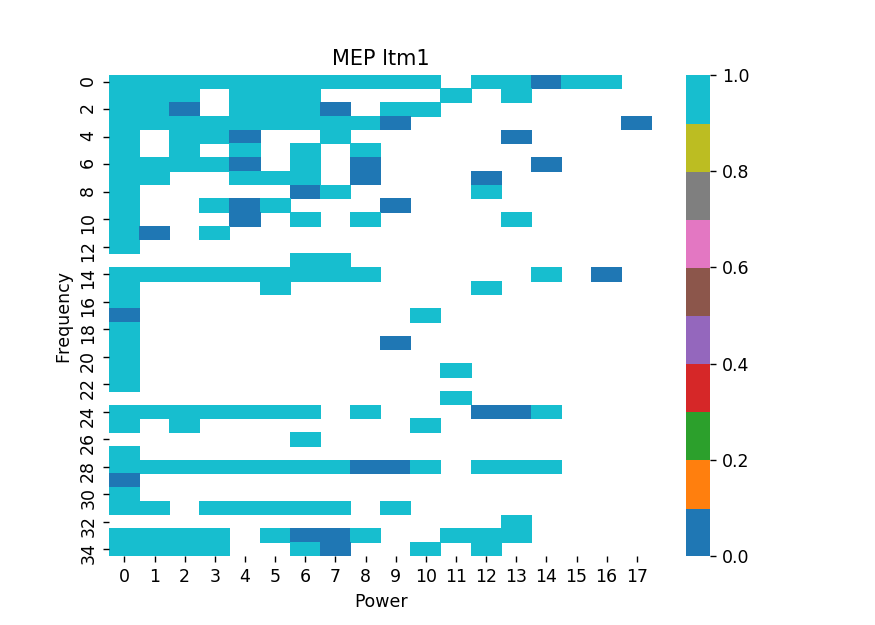

In [15]:
plt.figure(figsize=(7,5))
ax = sns.heatmap(df2.values, cmap='tab10', robust=True)
ax.set_xlabel('Power')
ax.set_ylabel('Frequency')
ax.set_title('MEP ' + channel)
plt.show()

In [16]:
df2 = df[df[mep_metric] == 0]
df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
df2['power_group_left'] = df2['power_group'].apply(lambda x: x.left)
df2 = df2.groupby(['power_group_left', 'wavelet_'+channel+'_max_power_at_freq']).count()
df2 = df2.pivot_table(mep_metric, index='power_group_left', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc='sum')
df2.tail()

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


wavelet_ltm1_max_power_at_freq,6.024261036749769,6.569503244169645,7.164094087536494,7.8125,8.519591661447327,9.290680585958759,10.13155902071101,11.04854345603981,12.04852207349954,13.13900648833929,14.32818817507299,17.03918332289465,18.58136117191752,20.26311804142203,28.65637635014598,31.25
power_group_left,,,,,,,,,,,,,,,,
13292.929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13434.343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13575.758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13717.172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13858.586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
def plot_heatmap(df2, title):
    title = title + ' - ' + str(df2.shape[0]) + ' MEPs'
    df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
    df2['power_group_left'] = df2['power_group'].apply(lambda x: x.left)
    df2 = df2.groupby(['power_group_left', 'wavelet_'+channel+'_max_power_at_freq']).count()
    df2 = df2.pivot_table(mep_metric, index='power_group_left', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc='sum', fill_value=0, dropna=False)
    df2 = df2.sort_index(axis=1)
    df2 = df2.sort_index(axis=0)
    
    plt.figure(figsize=(9,8))
    ax = sns.heatmap(df2.values, cmap='viridis', robust=True, xticklabels=df2.columns, yticklabels=df2.index)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    ax.set_title(title)
    plt.show()

In [18]:
df[df[mep_metric] == 0].head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time,mep_category_cmap_across_subjects,power_group
14,0.000001,3.121806e-16,8,0.000001,3.121806e-16,8,2.364657e-16,26,7.839183e-17,2,...,11.048543,-0.236421,867.820794,395.430090,0.976562,-0.100608,2678.143935,510.809053,0.0,"(848.485, 989.899]"
32,0.000003,4.976859e-16,26,0.000003,4.293950e-16,10,4.976859e-16,26,4.156717e-16,4,...,6.024261,-0.232024,1874.872417,475.792470,4.259796,-0.241795,5254.148707,885.050451,0.0,"(1838.384, 1979.798]"
2,0.000006,8.744943e-15,36,0.000006,4.910167e-15,12,4.360492e-15,28,1.636866e-15,4,...,20.263118,-0.325823,1708.952027,874.040196,0.976562,-0.075693,147334.851180,32360.804338,0.0,"(1696.97, 1838.384]"
10,0.000009,4.493977e-15,30,0.000009,1.824112e-15,8,4.493977e-15,30,5.492521e-16,2,...,6.569503,-0.473848,1053.553442,356.750606,0.976562,-0.062991,332882.893999,44371.584336,0.0,"(989.899, 1131.313]"
18,0.000004,2.678136e-15,6,0.000004,8.391464e-16,12,2.644468e-15,28,2.668122e-15,4,...,17.039183,-0.347807,442.586271,238.525745,0.976562,-0.230558,14746.676920,3990.706782,0.0,"(424.242, 565.657]"


In [19]:
from itertools import product

In [20]:
df4 = pd.DataFrame({"group":[1,1,1 ,2,2],
                   "cat": ['a', 'b', 'c', 'a', 'c'] ,
                   "value": range(5),
                   "value2": np.array(range(5))* 2})
df4

,group,cat,value,value2
0,1,a,0,0
1,1,b,1,2
2,1,c,2,4
3,2,a,3,6
4,2,c,4,8


In [21]:
dfo = pd.DataFrame(list(product(df4['group'].unique(), df4['cat'].unique())), columns=['group', 'cat'])
dfo

,group,cat
0,1,a
1,1,b
2,1,c
3,2,a
4,2,b
5,2,c


In [22]:
dfo.merge(df4, how='left').fillna(0)

,group,cat,value,value2
0,1,a,0.0,0.0
1,1,b,1.0,2.0
2,1,c,2.0,4.0
3,2,a,3.0,6.0
4,2,b,0.0,0.0
5,2,c,4.0,8.0


In [23]:
def plot_heatmap2(df2, title, df_all):
    title = title + ' - ' + str(df2.shape[0]) + ' MEPs'
    df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
    df2['power_group_left'] = df2['power_group'].apply(lambda x: x.left)
    
    all_power_group = pd.cut(df_all['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
    all_power_group = all_power_group.apply(lambda x: x.left)
    
    df2 = df2.groupby(['power_group_left', 'wavelet_'+channel+'_max_power_at_freq']).count()
    df2 = df2.reset_index()
    df3 = pd.DataFrame(list(product(all_power_group.unique(), df_all['wavelet_'+channel+'_max_power_at_freq'].unique())), columns=['power_group_left', 'wavelet_'+channel+'_max_power_at_freq'])
    # df3 = pd.DataFrame(list(product(df2['power_group_left'].unique(), df2['wavelet_'+channel+'_max_power_at_freq'].unique())), columns=['power_group_left', 'wavelet_'+channel+'_max_power_at_freq'])
    df3 = df3.merge(df2, how='left').fillna(0)
    # print(df3.shape)
    df3 = df3.pivot_table(mep_metric, index='power_group_left', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc='sum')
    df3 = df3.sort_index(axis=1)
    df3 = df3.sort_index(axis=0)
    
    plt.figure(figsize=(9,8))
    ax = sns.heatmap(df3.values, cmap='viridis', robust=True, xticklabels=df3.columns, yticklabels=df3.index)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    ax.set_title(title)
    plt.show()

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


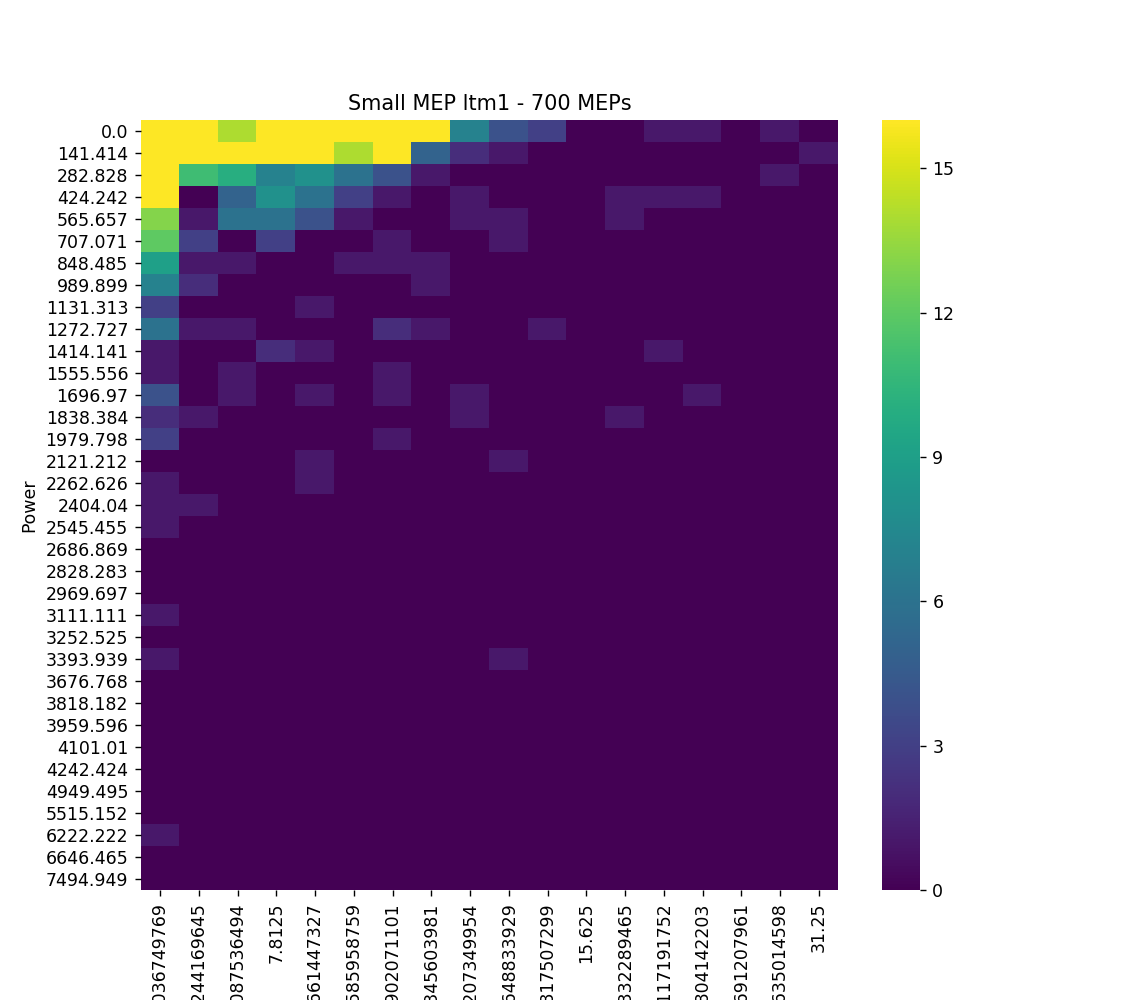

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


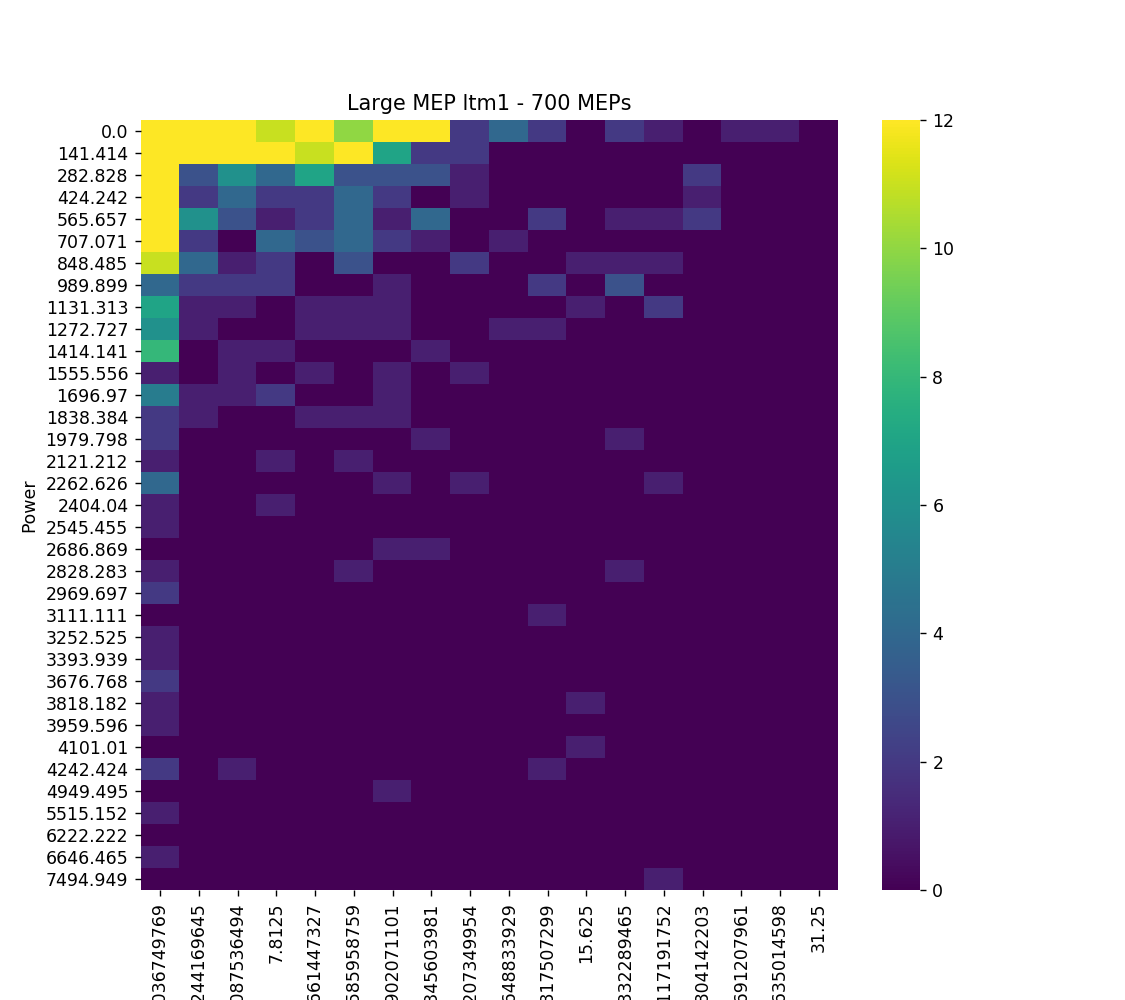

In [26]:
plot_heatmap2(df[df[mep_metric] == 0], 'Small MEP ' + channel, df)
plot_heatmap2(df[df[mep_metric] == 1], 'Large MEP ' + channel, df)